In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
import gc
import os
from tqdm import tqdm
from scipy.sparse import csr_matrix
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## data processing

In [2]:
# read data

fileFolder = 'm5-forecasting-accuracy/'

calendar = pd.read_csv(fileFolder+'calendar.csv')
sell_prices = pd.read_csv(fileFolder+'sell_prices.csv')
sales_train_val = pd.read_csv(fileFolder+'sales_train_validation.csv')
submission = pd.read_csv(fileFolder+'sample_submission.csv')

NUM_ITEMS = sales_train_val.shape[0]  # item number is 30490
DAYS_PRED = submission.shape[1] - 1  # prediction day is 28

In [3]:
# encode categotiacal columns
def encode_categorical(df, cols):
    
    for col in cols:
        encoder = LabelEncoder()
        #not_null = df[col][df[col].notnull()]
        df[col] = df[col].fillna('nan')
        df[col] = pd.Series(encoder.fit_transform(df[col]), index=df.index)
    return df

In [4]:
calendar = encode_categorical(calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"])
sales_train_val = encode_categorical(sales_train_val, ["item_id", "dept_id", "cat_id", "store_id", "state_id"])
sell_prices = encode_categorical(sell_prices, ["item_id", "store_id"])

In [5]:
# reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: 
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
sales_train_val = reduce_mem_usage(sales_train_val)

Mem. usage decreased to  0.07 Mb (61.4% reduction)
Mem. usage decreased to 45.67 Mb (70.8% reduction)
Mem. usage decreased to 94.01 Mb (78.9% reduction)


In [7]:
d_name = ['d_' + str(i+1) for i in range(1913)]
sales_train_val = pd.melt(sales_train_val,
                                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                     var_name = 'day', value_name = 'sales')

In [8]:
sales_train_val.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0


In [9]:
product = sales_train_val[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

# seperate dataframes
test1_rows = [row for row in submission['id'] if 'validation' in row]
test2_rows = [row for row in submission['id'] if 'evaluation' in row]

test1 = submission[submission['id'].isin(test1_rows)]
test2 = submission[submission['id'].isin(test2_rows)]
test1.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
test2.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

test2['id'] = test2['id'].str.replace('_evaluation','_validation')

test1 = test1.merge(product, how = 'left', on = 'id')
test2 = test2.merge(product, how = 'left', on = 'id')
test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'sales')

test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                var_name = 'day', value_name = 'sales')

sales_train_val['part'] = 'train'
test1['part'] = 'test1'
test2['part'] = 'test2'

data = pd.concat([sales_train_val, test1, test2], axis = 0)

del sales_train_val, test1, test2
data = data[data['part'] != 'test2']

gc.collect()

0

In [10]:
#merge calendar
calendar.drop(['weekday', 'wday', 'month', 'year'], 
              inplace = True, axis = 1)
data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
data.drop(['d', 'day'], inplace = True, axis = 1)

del  calendar
gc.collect()

#merge sell price
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')

del  sell_prices
gc.collect()

20

0

In [11]:
data.head(5)
data.to_pickle('data_merged.pickle')

,id,item_id,dept_id,cat_id,store_id,state_id,sales,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,0,train,2011-01-29,11101,30,4,4,2,0,0,0,NaN


## feature engineering

In [12]:
data["date"] = pd.to_datetime(data["date"])

# date format asserted
attrs = [
    "year",
    "month",
    "week",
    "dayofweek",
]

for attr in tqdm(attrs):
    dtype = np.int16 if attr == "year" else np.int8
    data[attr] = getattr(data["date"].dt, attr).astype(dtype)

# make column of lastweek_sellprice 
tmp_data = data[['id','wm_yr_wk','sell_price']]
tmp_data = tmp_data.drop_duplicates()
tmp_data.columns = ['id','wm_yr_wk','lastweek_sell_price']
tmp_data['wm_yr_wk'] = tmp_data['wm_yr_wk']+1
data = pd.merge(data, tmp_data, on=['id','wm_yr_wk'], how='left', copy=False)
del tmp_data
gc.collect()


# make a feature of price change in a week rate
data["price_change_week"] = data["sell_price"]/data["lastweek_sell_price"]
data.drop(["lastweek_sell_price"], inplace = True, axis =1)
print("make feature: price_change_week success ")

# make item demand rollling 7 days mean window
windows = [7]
for window in tqdm(windows):
    data['rolling_sales_mean_'+str(window)] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(window=window).mean()).astype(np.float16)
print("make feature: item sales rollling 7 days maen window success")



for window in tqdm(windows):
    data['last_year_rolling_sales_mean'] = data.groupby(['id'],as_index=False)['rolling_sales_mean_'+str(window)].shift(365).astype(np.float16)
print("make feature: item sales 1 year window success")


lags = [1,7, 28]
for lag in tqdm(lags):
    data['sales_lag_'+str(lag)] = data.groupby(['id'],as_index=False)['sales'].shift(lag).astype(np.float16)
print("make feature: sales lags success")


data = reduce_mem_usage(data)
gc.collect()
data.to_pickle("data_with_feature.pickle")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:35<00:00,  9.00s/it]


45

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

make feature: price_change_week success 


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

make feature: item sales rollling 7 days maen window success


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

make feature: item sales 1 year window success


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.13s/it]


make feature: sales lags success
Mem. usage decreased to 3837.89 Mb (8.1% reduction)


78

## model and submission

In [13]:
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['sales']


x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['sales']

test = data[(data['date'] > '2016-04-24')]

In [14]:
features = [
    "cat_id",
    "dept_id",
    "item_id",
    "state_id",
    "store_id",
    "event_name_1",
    "event_name_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",

    "rolling_sales_mean_7",
    "last_year_rolling_sales_mean",
    "sales_lag_1",
    "sales_lag_7",
    "sales_lag_28",

    "sell_price",
    "price_change_week",

    "year",
    "month",
    "dayofweek",
    "wm_yr_wk",
]

params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 72,
    'learning_rate': 0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75}

train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)



model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 10, valid_sets = [train_set, val_set], verbose_eval = 100)
val_pred = model.predict(x_val[features])
y_pred = model.predict(test[features])

test['demand'] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 7.411326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1869
[LightGBM] [Info] Number of data points in the train set: 57473650, number of used features: 21
[LightGBM] [Info] Start training from score 1.122458
Training until validation scores don't improve for 10 rounds
[100]	training's rmse: 1.80777	valid_1's rmse: 1.72546
Early stopping, best iteration is:
[115]	training's rmse: 1.80173	valid_1's rmse: 1.72465


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

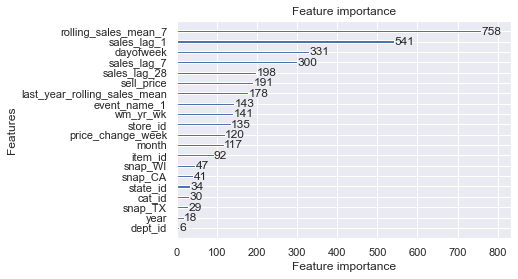

In [15]:
# 查看特征重要性
lgb.plot_importance(model)

In [16]:
# submission

predictions = test[['id', 'date', 'sales']]

predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')

submission = pd.concat([validation, evaluation])
submission.to_csv('submission.csv', index = False)